In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Generate simulated reflectometry signal

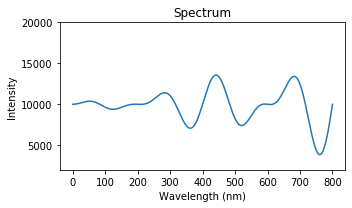

In [2]:
n = 1000
t = 1/800
x = np.linspace(0,800,799)
y = (500*np.sin(2* 2*np.pi * x) + 350*np.sin(3 * 2*np.pi * x))*(0.01*x) + 10000

fig, ax = plt.subplots(figsize=(5,3))
plt.plot(x, y)
plt.title("Spectrum")
plt.ylim(2000,20000)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.tight_layout()

## Data augmentation on simulated reflectometry signal

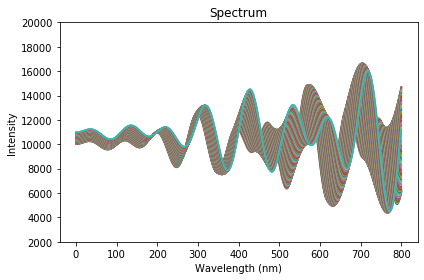

In [3]:
n = 1000
t = 1/800
x = np.linspace(0,800,799)

sample = 100

data = np.zeros((sample, 799))

for i in range(sample):
    y = (500*np.sin(2*np.pi * x * 0.001*(10+(sample-i)/sample)) + 350*np.sin(3 * 2*np.pi * x))*(0.01*x) + 10000 + 10*i
    data[i,:] = y
    plt.plot(x, y)
    plt.ylim(2000,20000)
    plt.title("Spectrum")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.tight_layout()

## Normalize the spectrum

In [4]:
data.shape

(100, 799)

In [5]:
scaler = MinMaxScaler((4000,16000))
data_T = scaler.fit_transform(data.transpose())
data = data_T.transpose()
data.shape

(100, 799)

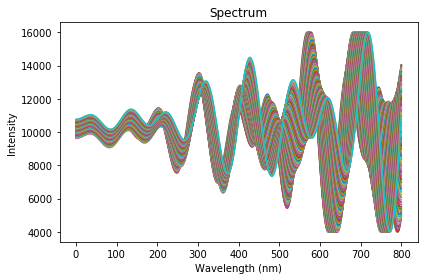

In [6]:
for i in range(sample):
    y = data[i,:]
    plt.plot(x, y)
    plt.title("Spectrum")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.tight_layout()

## Fourier transformation function

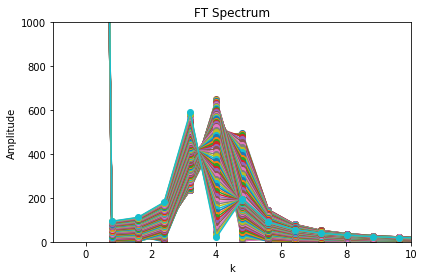

In [7]:
data_ft = np.zeros((sample, int(n/2)))
xf = np.linspace(0,1/(2*t),n/2)

for i in range(sample):
    data_ft[i,:] = fft(data[i,:int(n/2)])
    yf = 2/n * np.abs(data_ft[i,:])
    data_ft[i,:] = yf
    plt.plot(xf, yf, "-o")
    plt.ylim(0,1000)
    plt.xlim(-1,10)
    plt.title("FT Spectrum")
    plt.xlabel("k")
    plt.ylabel("Amplitude")
    plt.tight_layout()

## Fourier-transformed dataset overview

In [8]:
df_ft = pd.DataFrame(data_ft, columns=np.round(xf,2))
df_ft.head()

,0.00,0.80,1.60,2.40,3.21,4.01,4.81,5.61,6.41,7.21,...,392.79,393.59,394.39,395.19,395.99,396.79,397.60,398.40,399.20,400.00
0,10145.408931,83.244646,87.007219,65.004787,243.005235,477.586352,495.763870,144.777044,78.609504,51.212878,...,36.490318,51.212878,78.609504,144.777044,495.763870,477.586352,243.005235,65.004787,87.007219,83.244646
1,10099.179713,84.196879,88.077258,66.134178,243.514524,491.701901,490.279532,145.214734,79.099802,51.623187,...,36.832790,51.623187,79.099802,145.214734,490.279532,491.701901,243.514524,66.134178,88.077258,84.196879
2,10050.775127,85.111693,89.103629,67.188553,244.320182,506.073050,484.743916,145.589027,79.555160,52.010717,...,37.158968,52.010717,79.555160,145.589027,484.743916,506.073050,244.320182,67.188553,89.103629,85.111693
3,10002.752596,85.914659,90.008216,68.107600,245.220939,520.268126,478.741332,145.774512,79.906769,52.330394,...,37.436607,52.330394,79.906769,145.774512,478.741332,520.268126,245.220939,68.107600,90.008216,85.914659
4,10030.062201,85.610296,89.747127,68.097437,243.401292,528.141248,466.868535,144.099474,79.234718,51.978507,...,37.233130,51.978507,79.234718,144.099474,466.868535,528.141248,243.401292,68.097437,89.747127,85.610296


In [9]:
df_ft_reduced = df_ft.iloc[:, 1:10].copy()
df_ft_reduced.head()

,0.80,1.60,2.40,3.21,4.01,4.81,5.61,6.41,7.21
0,83.244646,87.007219,65.004787,243.005235,477.586352,495.763870,144.777044,78.609504,51.212878
1,84.196879,88.077258,66.134178,243.514524,491.701901,490.279532,145.214734,79.099802,51.623187
2,85.111693,89.103629,67.188553,244.320182,506.073050,484.743916,145.589027,79.555160,52.010717
3,85.914659,90.008216,68.107600,245.220939,520.268126,478.741332,145.774512,79.906769,52.330394
4,85.610296,89.747127,68.097437,243.401292,528.141248,466.868535,144.099474,79.234718,51.978507


## Generate simulated depth as target label

In [10]:
depth = [0.1*i + 50 + np.random.random() for i in range(sample)]

Text(0, 0.5, 'Depth')

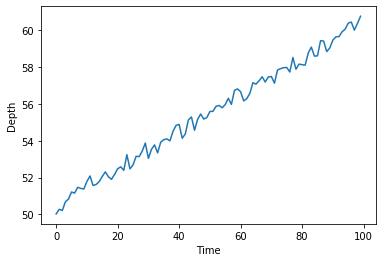

In [11]:
plt.plot(depth)
plt.xlabel("Time")
plt.ylabel("Depth")

In [12]:
df_ft_reduced["Depth"] = depth
df_ft_reduced.head()

,0.8,1.6,2.4,3.21,4.01,4.81,5.61,6.41,7.21,Depth
0,83.244646,87.007219,65.004787,243.005235,477.586352,495.763870,144.777044,78.609504,51.212878,50.027295
1,84.196879,88.077258,66.134178,243.514524,491.701901,490.279532,145.214734,79.099802,51.623187,50.279864
2,85.111693,89.103629,67.188553,244.320182,506.073050,484.743916,145.589027,79.555160,52.010717,50.213562
3,85.914659,90.008216,68.107600,245.220939,520.268126,478.741332,145.774512,79.906769,52.330394,50.684281
4,85.610296,89.747127,68.097437,243.401292,528.141248,466.868535,144.099474,79.234718,51.978507,50.834202


## Build Machine Learning models

In [13]:
lr = LinearRegression()

In [14]:
en = ElasticNet()

In [15]:
rf = RandomForestRegressor()

## 10-fold cross validation

In [16]:
kf = KFold(n_splits=10)
lr_mse_list = []
en_mse_list = []
rf_mse_list = []

df_ft_reduced_shuffled = df_ft_reduced.sample(frac=1)

X = np.asarray(df_ft_reduced_shuffled.iloc[:, :-1])
y = np.asarray(df_ft_reduced.sample(frac=1)["Depth"]).reshape(sample,)

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    lr.fit(X_train, y_train)
    en.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    
    pred_lr = lr.predict(X_test)
    pred_en = en.predict(X_test)
    pred_rf = rf.predict(X_test)
    
    mse_lr = mean_squared_error(y_test, pred_lr)
    mse_en = mean_squared_error(y_test, pred_en)
    mse_rf = mean_squared_error(y_test, pred_rf)
    
    lr_mse_list.append(mse_lr)
    en_mse_list.append(mse_en)
    rf_mse_list.append(mse_rf)

In [17]:
np.mean(lr_mse_list), np.mean(en_mse_list), np.mean(rf_mse_list)

(9.24924580998393, 9.18027949853084, 11.948323934071546)

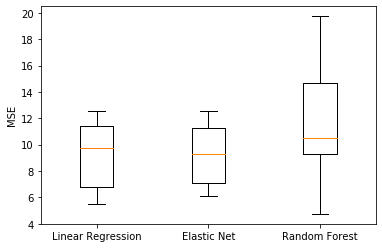

In [18]:
plt.boxplot([lr_mse_list, en_mse_list, rf_mse_list], sym="")
plt.xticks([1,2,3],["Linear Regression", "Elastic Net", "Random Forest"])
plt.ylabel("MSE");

## Learning curve

In [19]:
lr = LinearRegression()
en = ElasticNet()
rf = RandomForestRegressor()
model_list = [lr, en, rf]
model_name_list = ["Linear Regression", "Elastic Net", "Random Forest"]

In [20]:
size_list = np.linspace(0.1,0.9,9)
size_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

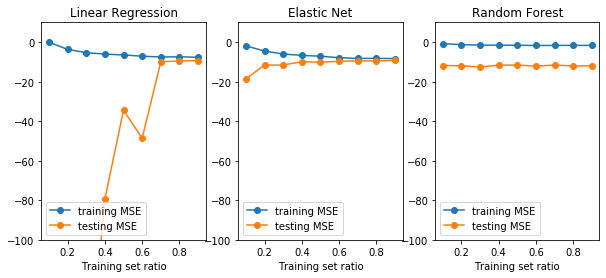

In [21]:
size_list = np.linspace(0.1,0.9,9)

fig = plt.figure(figsize=(10,4))

for index, m in enumerate(model_list):
    train_sizes, train_scores, test_scores = learning_curve(m, X, y, train_sizes=size_list,
                                                            cv=10, scoring='neg_mean_squared_error')
    train_mean_list = []
    test_mean_list = []
    
    for i in range(len(size_list)):
        train_mean = np.mean(train_scores[i])
        test_mean = np.mean(test_scores[i])

        train_mean_list.append(train_mean)
        test_mean_list.append(test_mean)    
    
    ax = fig.add_subplot(1,3,index+1)
    plt.plot(size_list, train_mean_list, "-o", label="training MSE")
    plt.plot(size_list, test_mean_list, "-o", label="testing MSE")
    plt.ylim(-100, 10)
    plt.legend()
    plt.xlabel("Training set ratio")
    plt.title("{}".format(model_name_list[index]))

## Finding
* __Elastic Net__ is a better algorithm for performing machine learning on spectral data with FFT